In [12]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS, TFT, PatchTST, TCN, DLinear, RNN, LSTM, Autoformer, BiTCN
from neuralforecast.auto import AutoLSTM

from neuralforecast.losses.pytorch import MQLoss, MAE
import torch
import logging

# Set logging and seed for reproducibility
logging.basicConfig(level=logging.INFO)
torch.set_float32_matmul_precision('high')  # Optimize matrix multiplication precision
np.random.seed(42)


In [13]:
# %%
# 📌 Load Data
df = pd.read_csv("Data/Top_12_German_Companies_Financial_Data.csv")

In [14]:
# Select company
company = 'Merck KGaA'
sap_df = df[df["Company"] == company].copy()

# Convert date column and sort for proper time-series analysis
sap_df["Period"] = pd.to_datetime(sap_df["Period"], format="%m/%d/%Y")
sap_df = sap_df.sort_values(by="Period")

# Convert revenue to numeric and rename for NeuralForecast
sap_df["Revenue"] = pd.to_numeric(sap_df["Revenue"], errors="coerce")
sap_df = sap_df.rename(columns={"Period": "ds", "Revenue": "y"})
sap_df["unique_id"] = "all"  # Required by NeuralForecast
sap_df = sap_df[["unique_id", "ds", "y"]]

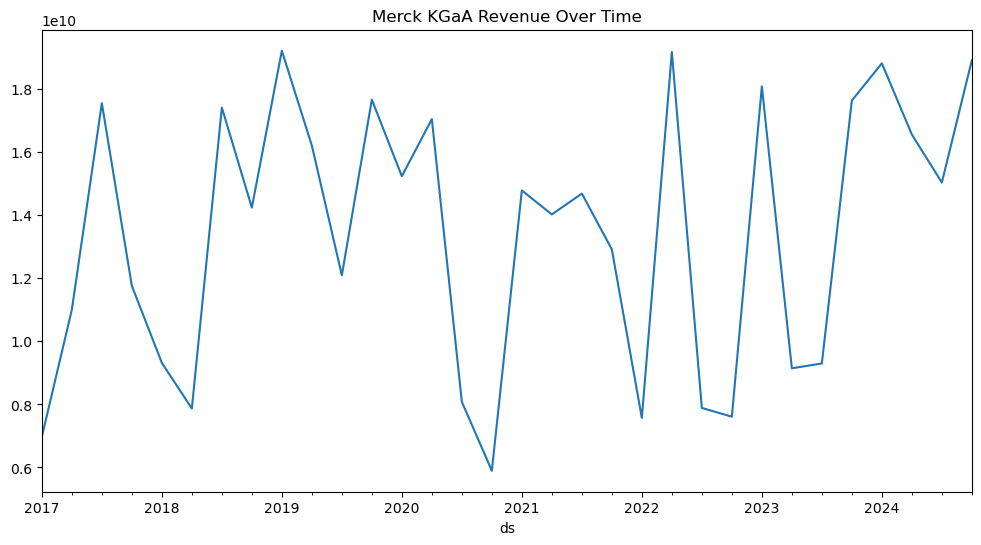

In [15]:
# Plot data
sap_df.plot(x="ds", y="y", figsize=(12, 6), title=f"{company} Revenue Over Time", legend=False)
plt.show()

In [16]:
# %%
# 📌 Train-Test Split
val_size = int(len(sap_df) * 0.2)
#val_size = 4 # int(len(sap_df) * 0.2)
train, val = sap_df[:-val_size], sap_df[-val_size:]

In [17]:
# 📌 Custom SMAPE function
def smape_loss(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# 📌 Model Evaluation Function
def evaluate_model(y_true, y_pred, model_name, start_time):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = smape_loss(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    runtime = time.time() - start_time

    return {
        "Model": model_name,
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "SMAPE": smape,
        "R² Score": r2,
        "Time (s)": runtime
    }


In [18]:
# 📌 Calculate Metrics for Each Model (Now Includes R² Score)
def calculate_metrics(y_true, y_pred):
    return {
        "MAE": np.mean(np.abs(y_true - y_pred)),
        "MSE": np.mean((y_true - y_pred) ** 2),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred) * 100,
        "SMAPE": smape_loss(y_true, y_pred),
        "R2 Score": r2_score(y_true, y_pred)  # ✅ Added R² Score
    }

In [19]:
# %%
# 📌 Define Models
def get_models(input_size=12):
    # Use your own config or AutoLSTM.default_config
    lstm_list = [TCN(h=hidden_neurons, input_size=input_size, loss=MQLoss(), alias=f'TCN_{hidden_neurons}') for hidden_neurons in [12, 24, 48, 96, 192]]
    return lstm_list


In [20]:
def walk_forward_validation(models, df, initial_train_size=0.6, forecast_horizon=12):
    """
    Perform Walk-Forward Validation with Expanding Training Window and Moving Test Set.
    Ensures the model is retrained at each step.
    """
    initial_train_split = int(len(df) * initial_train_size)  # Define initial training size
    results = {}

    for model in models:
        print(f"\n🚀 Running Expanding Window Walk-Forward Validation for {model.alias}...")

        predictions, actuals = [], []

        # Start with the initial training data
        train_end = initial_train_split

        while train_end < len(df) - forecast_horizon:
            train_df = df.iloc[:train_end]  # ✅ Training set expands at each step
            test_df = df.iloc[train_end:train_end + forecast_horizon]  # ✅ Test set moves forward

            # Ensure test set is not empty
            if test_df.empty:
                print(f"⚠ No test data available at train_end={train_end}. Breaking loop.")
                break

            # ✅ Train the model at each step (ensuring multiple training events)
            nf = NeuralForecast(models=[model], freq="Q")
            nf.fit(train_df)  # ✅ Retraining happens at each step

            # Generate predictions
            forecast_df = nf.predict()
            if forecast_df.empty:
                raise ValueError(f"Model {model.alias} returned empty predictions at train_end={train_end}.")

            # Handle different model output formats
            if f"{model.alias}-median" in forecast_df.columns:
                pred_column = f"{model.alias}-median"
            elif model.alias in forecast_df.columns:
                pred_column = model.alias
            else:
                raise ValueError(f"Expected column {model.alias} or {model.alias}-median missing in forecast output: {forecast_df.columns}")

            # Extract predictions for the forecast horizon
            pred_values = forecast_df.iloc[:forecast_horizon][pred_column].values
            predictions.extend(pred_values)

            # Get actual values for comparison
            actual_values = test_df["y"].values
            actuals.extend(actual_values)

            print(f"Step {train_end}: Trained on {len(train_df)} samples, Tested on {len(test_df)} samples")

            # ✅ Expand training window for next step
            train_end += forecast_horizon  # Move training forward step by step

        # Compute RMSE & MAPE
        if len(predictions) == 0 or len(actuals) == 0:
            raise ValueError(f"🚨 Predictions or Actuals list is empty for model {model.alias}")

        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mape = mean_absolute_percentage_error(actuals, predictions)

        results[model.alias] = calculate_metrics(np.array(actuals), np.array(predictions))

        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(df["ds"].values[len(df) - len(actuals):], actuals, label="Actual")
        plt.plot(df["ds"].values[len(df) - len(actuals):], predictions, label=f"{model.alias} Predictions", linestyle="dashed")
        plt.legend()
        plt.title(f"Expanding Window Walk-Forward Validation: {model.alias}")
        plt.savefig(f"Results/{model.alias}_walk_forward.png")
        plt.show()

    return results


In [21]:
sap_df

,unique_id,ds,y
352,all,2017-03-31,6974057939
353,all,2017-06-30,11003803134
354,all,2017-09-30,17552142118
355,all,2017-12-31,11760953647
356,all,2018-03-31,9318197850
357,all,2018-06-30,7868422908
358,all,2018-09-30,17415152986
359,all,2018-12-31,14241334382
360,all,2019-03-31,19217681417
361,all,2019-06-30,16209619277


Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1



🚀 Running Expanding Window Walk-Forward Validation for TCN_12...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 24.1 K | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
348 K     Trainable params
5         Non-trainable params
348 K     Total params
1.395     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True


Step 19: Trained on 19 samples, Tested on 4 samples


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 24.1 K | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
348 K     Trainable params
5         Non-trainable params
348 K     Total params
1.395     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 23: Trained on 23 samples, Tested on 4 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 24.1 K | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
348 K     Trainable params
5         Non-trainable params
348 K     Total params
1.395     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 27: Trained on 27 samples, Tested on 4 samples


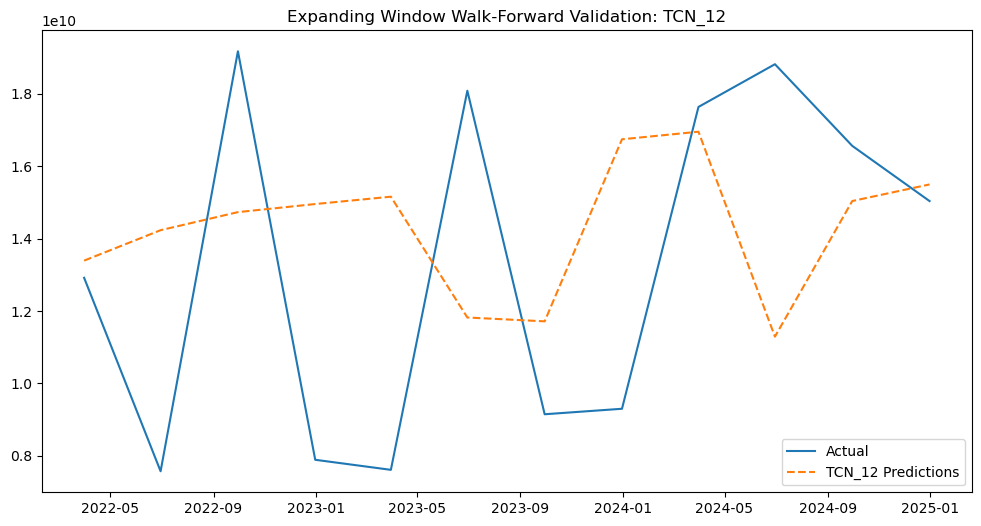

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



🚀 Running Expanding Window Walk-Forward Validation for TCN_24...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 48.2 K | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
372 K     Trainable params
5         Non-trainable params
372 K     Total params
1.491     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 19: Trained on 19 samples, Tested on 4 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 48.2 K | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
372 K     Trainable params
5         Non-trainable params
372 K     Total params
1.491     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Step 23: Trained on 23 samples, Tested on 4 samples


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 48.2 K | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
372 K     Trainable params
5         Non-trainable params
372 K     Total params
1.491     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 27: Trained on 27 samples, Tested on 4 samples


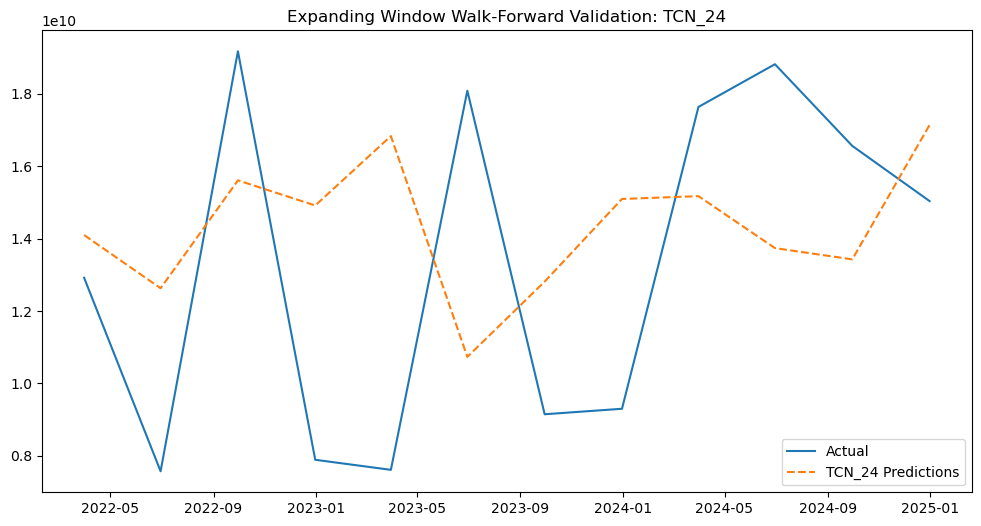

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



🚀 Running Expanding Window Walk-Forward Validation for TCN_48...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 96.5 K | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
421 K     Trainable params
5         Non-trainable params
421 K     Total params
1.684     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 19: Trained on 19 samples, Tested on 4 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 96.5 K | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
421 K     Trainable params
5         Non-trainable params
421 K     Total params
1.684     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 23: Trained on 23 samples, Tested on 4 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 96.5 K | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
421 K     Trainable params
5         Non-trainable params
421 K     Total params
1.684     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 27: Trained on 27 samples, Tested on 4 samples


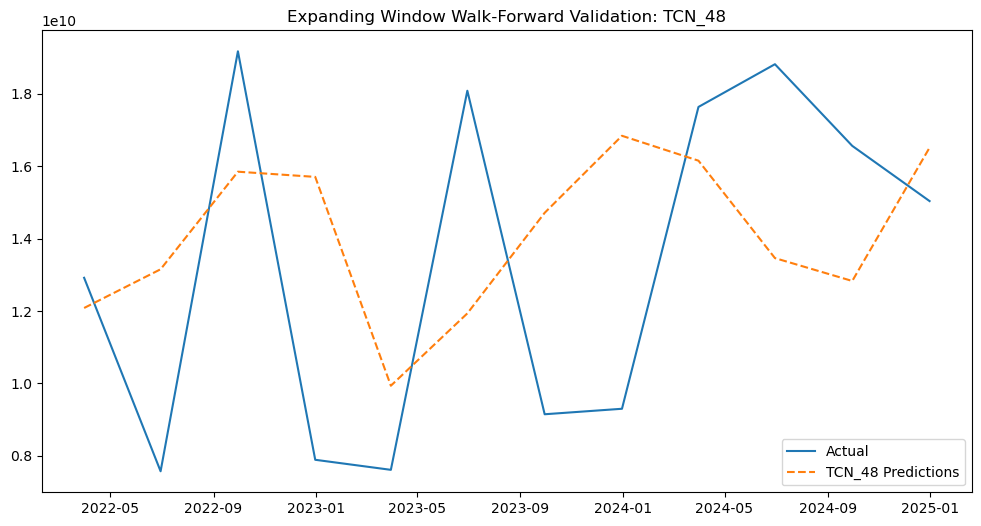


🚀 Running Expanding Window Walk-Forward Validation for TCN_96...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 192 K  | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
517 K     Trainable params
5         Non-trainable params
517 K     Total params
2.070     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 19: Trained on 19 samples, Tested on 4 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 192 K  | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
517 K     Trainable params
5         Non-trainable params
517 K     Total params
2.070     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 23: Trained on 23 samples, Tested on 4 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 192 K  | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
517 K     Trainable params
5         Non-trainable params
517 K     Total params
2.070     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 27: Trained on 27 samples, Tested on 4 samples


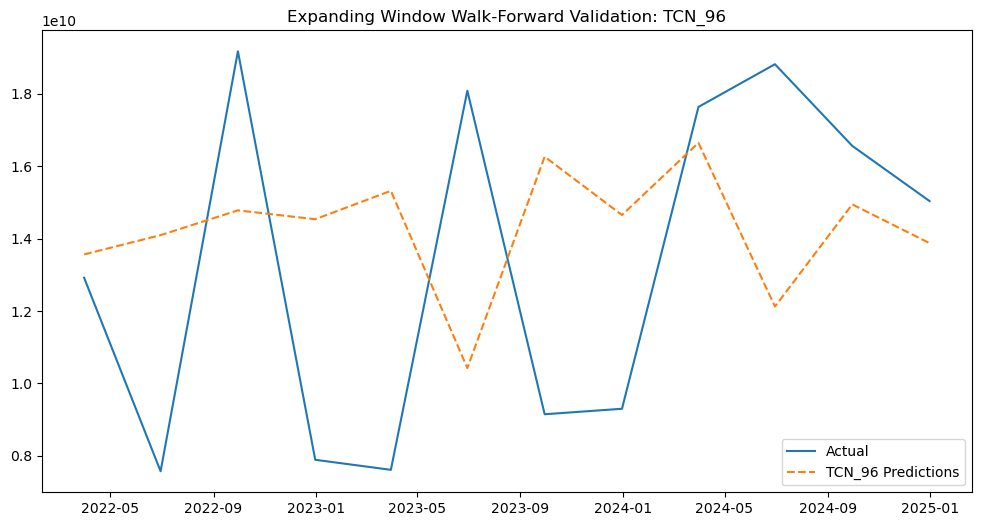


🚀 Running Expanding Window Walk-Forward Validation for TCN_192...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 385 K  | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
710 K     Trainable params
5         Non-trainable params
710 K     Total params
2.842     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 19: Trained on 19 samples, Tested on 4 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 385 K  | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
710 K     Trainable params
5         Non-trainable params
710 K     Total params
2.842     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True


Step 23: Trained on 23 samples, Tested on 4 samples


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 385 K  | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
710 K     Trainable params
5         Non-trainable params
710 K     Total params
2.842     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Step 27: Trained on 27 samples, Tested on 4 samples


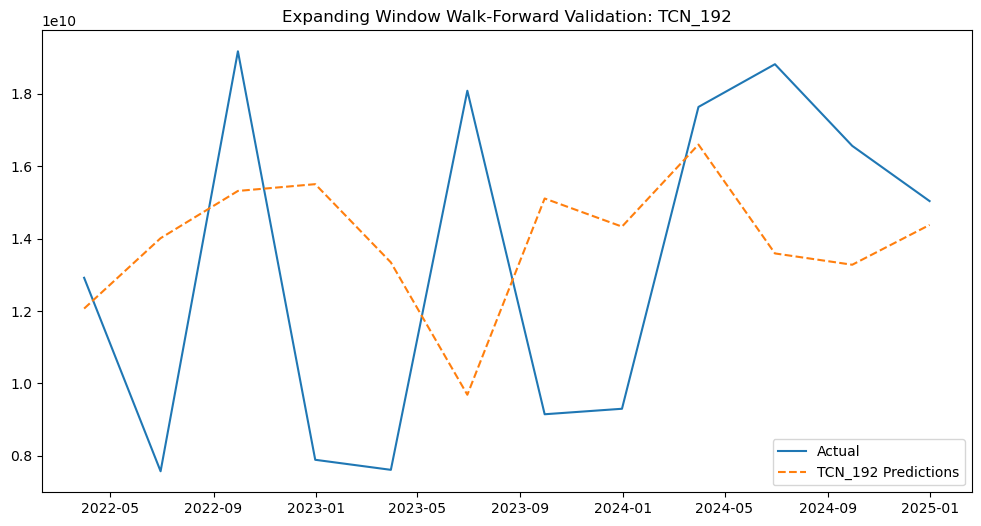

In [22]:
models = get_models(input_size=12)
wfv_results = walk_forward_validation(models, sap_df, forecast_horizon=4)

In [23]:
# 📊 Compare Walk-Forward Validation Results
sorted_results = sorted(wfv_results.items(), key=lambda x: x[1]["MAPE"], reverse=False)
print("\n📊 Walk-Forward Validation Model Performance (Sorted by MAPE Score):")
for model, scores in sorted_results:
    print(f"{model}: RMSE = {scores['RMSE']:.4f}, MAPE = {scores['MAPE']:.4f}, R² Score = {scores['R2 Score']:.4f}")


📊 Walk-Forward Validation Model Performance (Sorted by MAPE Score):
TCN_48: RMSE = 4849166506.8421, MAPE = 39.3688, R² Score = -0.1367
TCN_12: RMSE = 5261595412.8252, MAPE = 41.8780, R² Score = -0.3383
TCN_192: RMSE = 5156090855.2927, MAPE = 42.2743, R² Score = -0.2851
TCN_24: RMSE = 5175070677.3996, MAPE = 43.4805, R² Score = -0.2946
TCN_96: RMSE = 5429246234.6697, MAPE = 44.6766, R² Score = -0.4249


In [24]:
sorted_results

[('TCN_48',
  {'MAE': 4266496308.5833335,
   'MSE': 2.351441581107963e+19,
   'RMSE': 4849166506.842143,
   'MAPE': 39.36877351278408,
   'SMAPE': 32.867853473251934,
   'R2 Score': -0.1366795301437378}),
 ('TCN_12',
  {'MAE': 4389075629.75,
   'MSE': 2.768438628826364e+19,
   'RMSE': 5261595412.825243,
   'MAPE': 41.87796984244952,
   'SMAPE': 34.11798996196687,
   'R2 Score': -0.33825480937957764}),
 ('TCN_192',
  {'MAE': 4508652441.583333,
   'MSE': 2.658527290803328e+19,
   'RMSE': 5156090855.2927265,
   'MAPE': 42.27433778984993,
   'SMAPE': 35.482309189410316,
   'R2 Score': -0.2851238250732422}),
 ('TCN_24',
  {'MAE': 4637793880.416667,
   'MSE': 2.6781356516081504e+19,
   'RMSE': 5175070677.399633,
   'MAPE': 43.48053521608874,
   'SMAPE': 35.7156778167376,
   'R2 Score': -0.2946023941040039}),
 ('TCN_96',
  {'MAE': 4710076520.083333,
   'MSE': 2.9476714676675613e+19,
   'RMSE': 5429246234.669745,
   'MAPE': 44.67655127817623,
   'SMAPE': 36.614231484512615,
   'R2 Score': -0.4

In [25]:
# 📌 Select Best Model Based on Walk-Forward RMSE
best_model_name = sorted_results[0][0]
best_model = next(m for m in models if m.alias == best_model_name)

print(f"\n🚀 Best Model Selected: {best_model_name}")

# 📌 Train Best Model on Full Data and Generate Forecast
nf_best = NeuralForecast(models=[best_model], freq='Q')
nf_best.fit(df=train)

forecast_df = nf_best.predict()





🚀 Best Model Selected: TCN_48


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 96.5 K | train
5 | mlp_decoder     | MLP                        | 3.2 K  | train
-----------------------------------------------------------------------
421 K     Trainable params
5         Non-trainable params
421 K     Total params
1.684     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [26]:
# Evaluate Best Model
results = []
for model_name in forecast_df.columns:
    if model_name in ["ds", "unique_id"]:
        continue
    y_pred = forecast_df[model_name]
    results.append(evaluate_model(val["y"], y_pred[:len(val["y"])], model_name, time.time()))


In [27]:
# Convert results to DataFrame and display
df_results = pd.DataFrame(results).sort_values(by="MAPE", ascending=True)
print(df_results.head())

           Model           MSE           MAE      MAPE  SMAPE  R² Score  \
4   TCN_48-hi-90  1.745856e+19  3.465084e+09  0.240136    NaN -0.604774   
3   TCN_48-hi-80  1.886666e+19  3.611617e+09  0.246505    NaN -0.734205   
0  TCN_48-median  2.719130e+19  4.398547e+09  0.277349    NaN -1.499397   
2   TCN_48-lo-80  4.053167e+19  5.522380e+09  0.326389    NaN -2.725631   
1   TCN_48-lo-90  4.272953e+19  5.727364e+09  0.336054    NaN -2.927656   

   Time (s)  
4  0.004244  
3  0.005026  
0  0.012344  
2  0.003470  
1  0.005943  


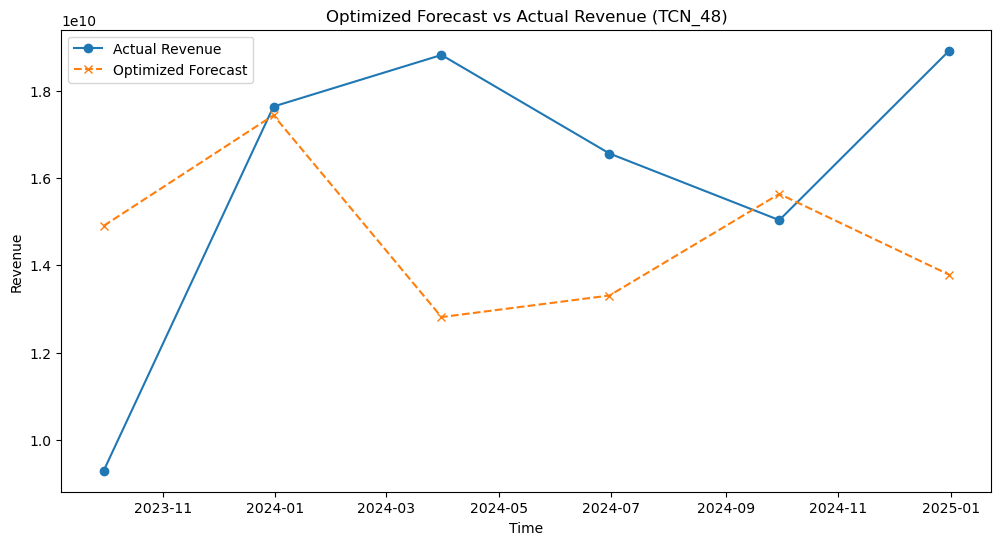

In [28]:
# %%
# 📌 Plot Optimized Forecast vs Actual
plt.figure(figsize=(12, 6))
plt.plot(val["ds"], val["y"], label="Actual Revenue", marker="o")
plt.plot(val["ds"], y_pred[:len(val["y"])], label="Optimized Forecast", linestyle="dashed", marker="x")
plt.xlabel("Time")
plt.ylabel("Revenue")
plt.title(f"Optimized Forecast vs Actual Revenue ({best_model_name})")
plt.legend()
plt.show()

In [29]:
forecast_df

,unique_id,ds,TCN_48-median,TCN_48-lo-90,TCN_48-lo-80,TCN_48-hi-80,TCN_48-hi-90
0,all,2023-09-30,1.314261e+10,1.081344e+10,1.111764e+10,1.473512e+10,1.490583e+10
1,all,2023-12-31,1.664411e+10,1.425175e+10,1.493361e+10,1.725358e+10,1.743790e+10
2,all,2024-03-31,1.065568e+10,9.168696e+09,9.273172e+09,1.252460e+10,1.281620e+10
3,all,2024-06-30,1.108492e+10,8.808544e+09,9.013090e+09,1.285643e+10,1.330992e+10
4,all,2024-09-30,1.419730e+10,1.189310e+10,1.229095e+10,1.540763e+10,1.563678e+10
5,all,2024-12-31,1.184085e+10,9.998700e+09,1.014407e+10,1.343728e+10,1.378693e+10
6,all,2025-03-31,1.568524e+10,1.396649e+10,1.453017e+10,1.597455e+10,1.624262e+10
7,all,2025-06-30,1.058218e+10,9.671432e+09,9.809797e+09,1.227485e+10,1.254701e+10
8,all,2025-09-30,9.419001e+09,8.345497e+09,8.261907e+09,1.207761e+10,1.244541e+10
9,all,2025-12-31,1.644880e+10,1.374287e+10,1.439431e+10,1.721801e+10,1.739020e+10


In [30]:
forecast_df.columns

Index(['unique_id', 'ds', 'TCN_48-median', 'TCN_48-lo-90', 'TCN_48-lo-80',
       'TCN_48-hi-80', 'TCN_48-hi-90'],
      dtype='object')

In [31]:
val

,unique_id,ds,y
378,all,2023-09-30,9297896247
379,all,2023-12-31,17637490503
380,all,2024-03-31,18818295502
381,all,2024-06-30,16561793827
382,all,2024-09-30,15036344926
383,all,2024-12-31,18915504026


In [32]:
train["ds"].max()

Timestamp('2023-06-30 00:00:00')

In [33]:
# # Generate forecast
# forecast_df = nf_best.predict().reset_index()
# model_name = best_model

# # Extract relevant columns
# # median_col = f"{model_name}-median"
# # lower_col = f"{model_name}-lo-0.1"  # 10% quantile
# # upper_col = f"{model_name}-hi-0.9"  # 90% quantile

# # Extract predictions
# median_pred = forecast_df[median_col].to_numpy()[:len(val["y"])]
# lower_pred = forecast_df[lower_col].to_numpy()[:len(val["y"])] if lower_col in forecast_df else median_pred - 5
# upper_pred = forecast_df[upper_col].to_numpy()[:len(val["y"])] if upper_col in forecast_df else median_pred + 5

# # Create future dates
# future_dates = pd.date_range(train["ds"].max(), periods=len(median_pred)+1, freq="Q")[1:]  # Ensure correct period range

# # Plot results
# plt.figure(figsize=(10, 5))

# # Plot actual data
# plt.plot(val["ds"], val["y"], label="Actual Data", marker="o", color="black")

# # Plot forecast
# plt.plot(future_dates, median_pred, label=f"{model_name} Median Forecast", linestyle="dashed", marker="x", color="blue")
# # plt.fill_between(future_dates, lower_pred, upper_pred, color="green", alpha=0.7, label="Confidence Interval (10-90%)")

# # Labels and Title
# plt.xlabel("Date")
# plt.ylabel("Value")
# plt.legend()
# plt.title(f"{model_name} Forecast with Quantiles for Next 4 Periods")
# plt.grid(True)

# # Save plot
# plt.savefig("forecast_plot.png")
# plt.show()

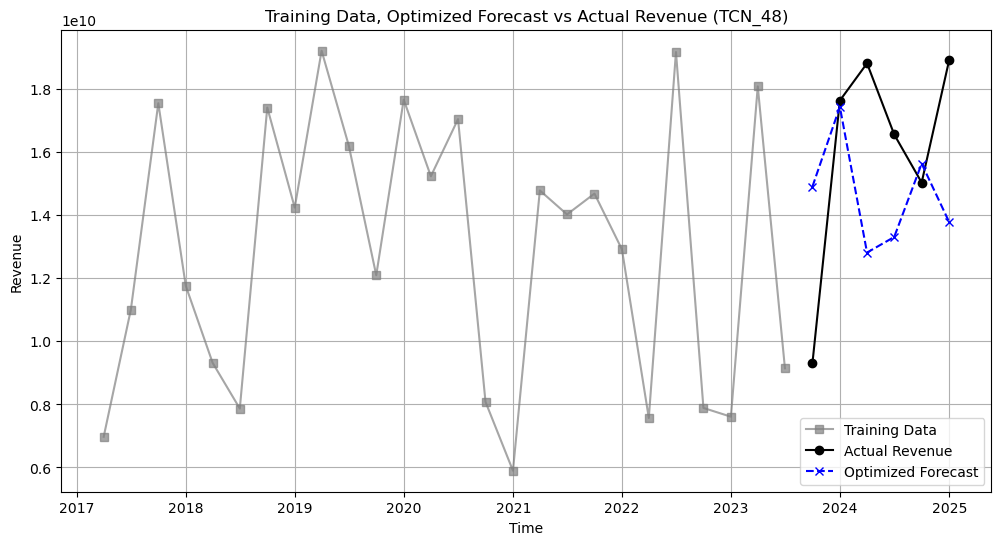

In [34]:
# %% 📌 Plot Train, Optimized Forecast, and Actual Data
plt.figure(figsize=(12, 6))

# Plot Training Data
plt.plot(train["ds"], train["y"], label="Training Data", marker="s", linestyle="-", color="gray", alpha=0.7)

# Plot Actual Validation Data
plt.plot(val["ds"], val["y"], label="Actual Revenue", marker="o", linestyle="-", color="black")

# Plot Optimized Forecast
plt.plot(val["ds"], y_pred[:len(val["y"])], label="Optimized Forecast", linestyle="dashed", marker="x", color="blue")

# Labels and Title
plt.xlabel("Time")
plt.ylabel("Revenue")
plt.title(f"Training Data, Optimized Forecast vs Actual Revenue ({best_model_name})")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [35]:
print(nf_best.models[0].loss)


MQLoss()


In [36]:
train["ds"].max()

Timestamp('2023-06-30 00:00:00')

In [37]:
forecast_df = nf_best.predict().reset_index()
model_name = best_model

c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\glsharma\AppData\Local\miniconda3\envs\forecasting\Lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]